## 1.0 Crawlling of All Available Courses on Go1

In [1]:
import pandas as pd
import time
import json
import requests
import functools
import operator
from pandas import json_normalize
import itertools
from collections import Counter
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

In [2]:
%%time
# Required details to call API
url = "https://api.go1.com/v2/learning-objects?limit=50&scroll=true"
headers = {'Authorization': 'eyJ0eXAiOiJKV1QiLCJhbGciOiJSUzI1NiJ9.eyJhdWQiOiJiNTJkYjdmNWM2ZmI3MjIzZWM5MWJlZmU0MzJiNjExNmM2N2U2YmFhIiwianRpIjoiY2QyY2U2M2U5MDI1MGEwNWU5ODU1MDBmNWEwNjE3MDIwNDkzNmUyMzFlYWY3NGQwYTVmMGEzNGQ5YjhlN2NiMDhjNWJjYjkwOTVlN2IzN2UiLCJpYXQiOjE2NTA5MzkzMTgsIm5iZiI6MTY1MDkzOTMxOCwiZXhwIjoxNjUwOTgyNTE3LCJzdWIiOiIxMDkyMjQ4NiIsInNjb3BlcyI6WyJhY2NvdW50LnJlYWQiLCJlbnJvbGxtZW50LnJlYWQiLCJsby5yZWFkIiwicG9ydGFsLnJlYWQiLCJ1c2VyLmxvZ2luLm1lIiwidXNlci5sb2dpbiIsInVzZXIucmVhZCIsImdyb3VwLnJlYWQiLCJ3ZWJob29rLnJlYWQiLCJ1c2VyLndyaXRlIiwiZW5yb2xsbWVudC53cml0ZSIsIndlYmhvb2sud3JpdGUiLCJncm91cC53cml0ZSIsImxvLndyaXRlIiwicG9ydGFsLndyaXRlIl19.BmLbZD_eyrG8PMl5eDaBrXskKSiymNDpjQIPgumT_ULqg2Gvf6eBZwS3BjKOfjOolkYM0PkGiMinou534hvxRslJdGfreySRUdUMqQc_NKhOtbg21katUskMRgf0Yh03dQKPWrFatnsI4wPTXUC8UfIjN10u0um3zrlw4LDanN_ejbTSAYn-DlZ3nf-glAUTLdeYcuMG4U002TDTSgcyXqa9exuJ1zttNVqZYkRWIM_ZtlHfu4Hf2Y67XLUKpaQay12jxSneZ3EtPlhyesTgXW3X9xJd1M4C2yOccCitB1QRBC9Uc4EdWQKUaCpaUEKltpP7IYPpaaHCW9bicXZ3dQ'}
result = []


# get first response
response = requests.get(url, headers=headers)
result.append(response.json())


# get scroll_id   
scroll_id = response.json()['_scroll_id']
scroll_id


# get subsequent response
error_counter = 0
while True:
    response = requests.get(url+'&scrollId='+scroll_id, headers=headers)
    if response.status_code != 200:
        error_counter += 1
        print('error encountered' + response.text)
        if error_counter <= 10:
            time.sleep(1)
            continue
        break
    response_json = response.json()
    if len(response_json['hits']) == 0:
        print('stop at empty hit')
        break
    result.append(response_json)

    
# Save the contents
with open('json_results/go1contents_2604.json', 'w') as json_file:
    json.dump(result, json_file)

error encountered{"message":"cURL error 35: OpenSSL SSL_connect: Connection reset by peer in connection to a3ee6fd84cf44a0db3564ac92b1e6069.ap-southeast-2.aws.found.io:9243 "}
stop at empty hit
CPU times: total: 27.4 s
Wall time: 23min 22s


## 2.0 Transforming Data into a Reable Format

In [2]:
# Opening JSON file
f = open('json_results/go1contents_2604.json')
 
# returns JSON object as a dictionary
data = json.load(f)

In [3]:
%%time
ll = [item['hits'] for item in data]
courses = functools.reduce(operator.iconcat,ll, [])

CPU times: total: 15.6 ms
Wall time: 3.01 ms


In [4]:
with open('json_results/go1contents_2604_reg.json', 'w') as json_file:
    json.dump(courses, json_file)

In [4]:
len(courses)

80300

In [5]:
pd.set_option("display.max_column", None)
df = json_normalize(courses) 
type(df)

pandas.core.frame.DataFrame

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80300 entries, 0 to 80299
Data columns (total 52 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              80300 non-null  int64  
 1   type                            80300 non-null  object 
 2   title                           80300 non-null  object 
 3   published                       80300 non-null  bool   
 4   description                     80300 non-null  object 
 5   image                           80300 non-null  object 
 6   created_time                    80300 non-null  object 
 7   updated_time                    80300 non-null  object 
 8   decommission_time               0 non-null      object 
 9   remove_time                     0 non-null      object 
 10  language                        80300 non-null  object 
 11  tags                            80300 non-null  object 
 12  items                           

## 3.0 Initial Cleaning

In [7]:
# Quick stats on categorical variables
df.describe(include='O')

,type,title,description,image,created_time,updated_time,decommission_time,remove_time,language,tags,items,collections,summary,authors,delivery.mode,pricing.currency,provider.name,subscription.package,attributes.region_restrictions,attributes.wcag,attributes.topics,attributes.industry,attributes.playlist_type,attributes.locale,attributes.region_relevance,attributes.learning_outcomes,attributes.mobile_optimised,attributes.assessable,attributes.entry_level.value,provider.logo,attributes.entry_level,attributes.featured_locale
count,80300,80300,80300,80300,80300,80300,0,0,80300,80300,80300,80300,80300,80300,80300,80300,80300,80300,80299,80299,80299,80299,80299,68705,80299,40196,80299,80299,58589,73508,21710,165
unique,8,77255,40157,67194,80212,65065,0,0,36,11830,1,1,10024,405,1,6,246,1,16,3,138,1,1,3,15,23088,3,3,4,183,1,4
top,video,Time Management,<p>This video forms part of the course <i>'Cer...,https://media.go1static.com/image/upload/v1506...,2017-09-30T08:23:31+00:00,2019-12-10T03:55:33+00:00,NaN,NaN,en,[],[],[],,"[{'name': 'Creative Live', 'last_name': 'Live'...",self-paced,USD,CreativeLive,premium,"[{'value': 'GLOBAL', 'key': 163}]",,"[{'value': 'Technology Skills', 'key': 64}, {'...",[],,"[{'value': 'en-US', 'key': 493}]","[{'value': 'GLOBAL', 'key': 495}]","[IT audit process, IT governance, Systems and ...",1,,Suitable for everyone,https://res.cloudinary.com/go1/image/upload/v1...,[],US
freq,46075,19,718,145,3,12,NaN,NaN,73611,7432,80300,80300,69879,26589,80300,73624,26589,80300,47538,41229,12812,80299,80299,56653,68522,718,66777,61878,48472,26589,21710,60


#### Insights:
- **Tags** have many empty list (7432), need to check whether **Topics** would be a better indicator in this case
- **Collections, Items** have only empty list
- **Delivery.mode, Subscription.package, Attributes.entry_level** have only one value which do not bring any meaningful insight
- **Decommission_time, Remove_time** do not have any value 
- Might have 1 missing value in **Attributes.industry, Attributes.playlist_type** where these two variables are mostly empty

In [8]:
### 3.1 To replace the N/A in Attributes.industry and Attributes.playlist_type

df['attributes.industry'] = df['attributes.industry'].apply(lambda d: d if isinstance(d, list) else [])
df['attributes.playlist_type'] = df['attributes.playlist_type'].fillna('')

df[['attributes.industry','attributes.playlist_type']].describe(include='O')

,attributes.industry,attributes.playlist_type
count,80300,80300
unique,1,1
top,[],
freq,80300,80300


In [9]:
# Quick stats on numerical variables
df.describe()

,id,items_count,delivery.duration,pricing.price,pricing.tax,provider.id,subscription.licenses,attributes.roles,attributes.skills,attributes.provider,attributes.entry_level.key,attributes.featured_status,reviews.count,reviews.rating,attributes.featured_timestamp
count,8.030000e+04,80300.0,80300.000000,80300.0,80300.000000,8.030000e+04,80300.0,0.0,0.0,0.0,58589.000000,80299.000000,55.000000,55.000000,1.780000e+02
mean,1.488388e+07,0.0,52.282540,0.0,0.097011,8.667574e+06,-1.0,NaN,NaN,NaN,490.581338,0.001818,1.290909,4.636364,1.577153e+09
std,9.491009e+06,0.0,306.688879,0.0,0.980160,6.752781e+06,0.0,NaN,NaN,NaN,0.967570,0.042602,0.685099,1.310409,5.518933e+06
min,1.895648e+06,0.0,0.000000,0.0,0.000000,2.985720e+05,-1.0,NaN,NaN,NaN,488.000000,0.000000,1.000000,0.000000,1.573199e+09
25%,8.563289e+06,0.0,5.000000,0.0,0.000000,4.878185e+06,-1.0,NaN,NaN,NaN,491.000000,0.000000,1.000000,5.000000,1.576112e+09
50%,1.114854e+07,0.0,13.000000,0.0,0.000000,6.052050e+06,-1.0,NaN,NaN,NaN,491.000000,0.000000,1.000000,5.000000,1.576131e+09
75%,1.651112e+07,0.0,30.000000,0.0,0.000000,1.049435e+07,-1.0,NaN,NaN,NaN,491.000000,0.000000,1.000000,5.000000,1.576136e+09
max,3.647321e+07,0.0,30240.000000,0.0,10.000000,3.620712e+07,-1.0,NaN,NaN,NaN,491.000000,1.000000,4.000000,5.000000,1.644212e+09


#### Insights:
- **Attributes.roles, Attributes.skills, Attributes.provider** do not have any value
- **Items_count, Pricing.price** have only zero value which do not bring any meaningful insight

In [10]:
# Quick stats on boolean data
var = ['assessable', 'portal_collection', 'published','previewable','pricing.tax_included']

for each_var in var:
    print(each_var)
    print(df[each_var].value_counts())
    print()

assessable
True    80300
Name: assessable, dtype: int64

portal_collection
False    80300
Name: portal_collection, dtype: int64

published
True    80300
Name: published, dtype: int64

previewable
True     67151
False    13149
Name: previewable, dtype: int64

pricing.tax_included
False    51911
True     28389
Name: pricing.tax_included, dtype: int64



#### Insights:
- **Assessable, Portal_collection, Published** have only one value which do not bring any meaningful insight

### 3.1 Selected Attributes for further examination

In [11]:
# Drop those variables which do not have any value, only have empty list/zero value/one unique value which does not bring any insight
var_to_drop = ['collections', 'items', 'delivery.mode', 'subscription.package', 'attributes.entry_level', 
               'decommission_time', 'remove_time', 'attributes.industry', 'attributes.playlist_type', 
               'attributes.roles', 'attributes.skills', 'attributes.provider','items_count','pricing.price',
               'assessable', 'portal_collection', 'published']

df.drop(var_to_drop, axis=1, inplace=True)

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80300 entries, 0 to 80299
Data columns (total 35 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              80300 non-null  int64  
 1   type                            80300 non-null  object 
 2   title                           80300 non-null  object 
 3   description                     80300 non-null  object 
 4   image                           80300 non-null  object 
 5   created_time                    80300 non-null  object 
 6   updated_time                    80300 non-null  object 
 7   language                        80300 non-null  object 
 8   tags                            80300 non-null  object 
 9   summary                         80300 non-null  object 
 10  previewable                     80300 non-null  bool   
 11  authors                         80300 non-null  object 
 12  delivery.duration               

In [13]:
var = ['previewable', 'pricing.tax_included']

for i in var:
    df[i]= df[i].apply(lambda x: str(x))

## 4.0 Data Exploration

### 4.1 Type of Courses based on Previewable Option / Entry Level

In [14]:
type_data = pd.crosstab(index=df['type'],
                             columns=df['previewable'])
type_data = type_data.sort_values(by=['True','False'], ascending=False)
type_data

previewable,False,True
type,,
video,0,46075
interactive,0,21076
course,9234,0
link,3214,0
document,517,0
audio,99,0
text,50,0
integration,35,0


<Figure size 1800x720 with 0 Axes>

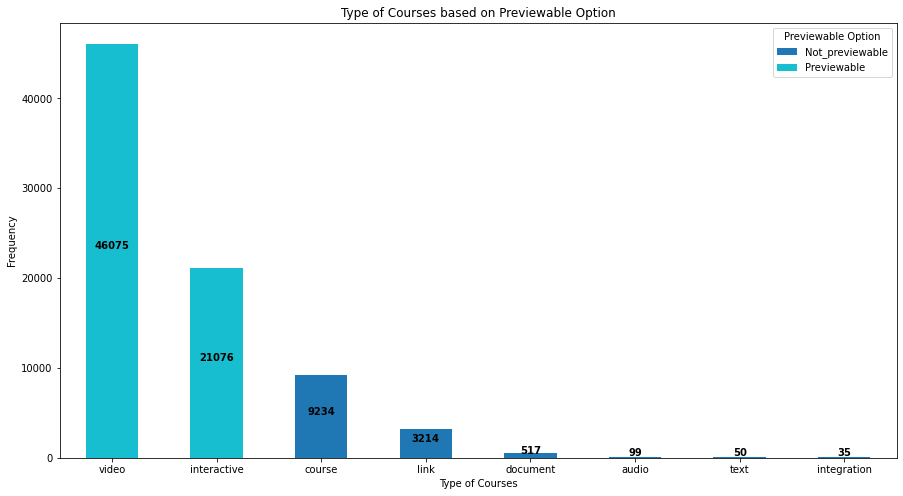

In [15]:
# Define Data
data = pd.DataFrame({
    'Not_previewable': list(type_data['False'].values),
    'Previewable': list(type_data['True'].values)
 })

course_type = list(df['type'].value_counts().keys())

# Plot stacked bar chart
ax = data.plot(stacked=True, kind='bar', colormap='tab10', figsize=(15, 8))

for bar in ax.patches:
    height = bar.get_height()
    width = bar.get_width()
    x = bar.get_x()
    y = bar.get_y()
    label_text = height
    if label_text != 0:
        label_x = x + width / 2
        label_y = y + height / 2
        ax.text(label_x, label_y,str('{0:.0f}'.format(label_text)), ha='center',    
                va='bottom', fontsize=10, fontweight="bold")

# Set Tick labels
ax.set_xticklabels(course_type,rotation='horizontal')

plt.legend(title='Previewable Option')
plt.ylabel("Frequency")
plt.xlabel("Type of Courses")
plt.title('Type of Courses based on Previewable Option')
plt.show()

plt.show()

#### Observation:
- It seems like video (57%) is the most popular type of contents being provided, followed by interactive and course-based contents
- Only video and interactive kind of courses are previewable
- For 67k of courses which are previewable, 93% do not provide summary
- For 13k of courses which are not previewable, 43% of them would contain summary
- Video, document and text are mobile optimised, while audio is the only format without mobile optimised

In [116]:
d = df[['previewable', 'summary']]
d['got_summary'] = d['summary'].apply(lambda x: 'No summary' if x=='' else 'Got summary')
pd.pivot_table(d, values='summary',index='previewable', columns=['got_summary'], aggfunc='count', margins=True)

C:\Users\Regina\AppData\Local\Temp\ipykernel_25072\4146096877.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d['got_summary'] = d['summary'].apply(lambda x: 'No summary' if x=='' else 'Got summary')


got_summary,Got summary,No summary,All
previewable,,,
False,5606,7543,13149
True,4815,62336,67151
All,10421,69879,80300


In [146]:
mol_opt = pd.crosstab(index=df['type'],columns=df['attributes.mobile_optimised'])
mol_opt.sort_values(by='1', ascending=False)

attributes.mobile_optimised,,0,1
type,,,
video,0,0,46075
interactive,5856,1591,13628
course,5647,291,3296
link,5,2,3207
document,0,0,517
text,0,0,50
integration,0,31,4
audio,99,0,0


In [150]:
# Only got one course without description
df[df['description']=='']

,id,type,title,description,image,created_time,updated_time,language,tags,summary,previewable,authors,delivery.duration,pricing.currency,pricing.tax,pricing.tax_included,provider.id,provider.name,subscription.licenses,attributes.region_restrictions,attributes.wcag,attributes.topics,attributes.locale,attributes.region_relevance,attributes.learning_outcomes,attributes.mobile_optimised,attributes.assessable,attributes.entry_level.value,attributes.entry_level.key,attributes.featured_status,provider.logo,attributes.featured_locale,reviews.count,reviews.rating,attributes.featured_timestamp,attributes.topics.list
72487,36179704,course,UQ Sport - Code of Conduct Training Course,,https://media.go1static.com/image/upload/v1633...,2021-07-01T03:51:21+00:00,2021-11-21T22:58:49+00:00,en,[],,False,[],0,USD,0,False,2490409,UQ Sport Learning,-1,"[{'value': 'GLOBAL', 'key': 163}]",,[],NaN,[],None,,,NaN,NaN,0.0,https://res.cloudinary.com/go1/image/upload/v1...,NaN,NaN,NaN,NaN,[]


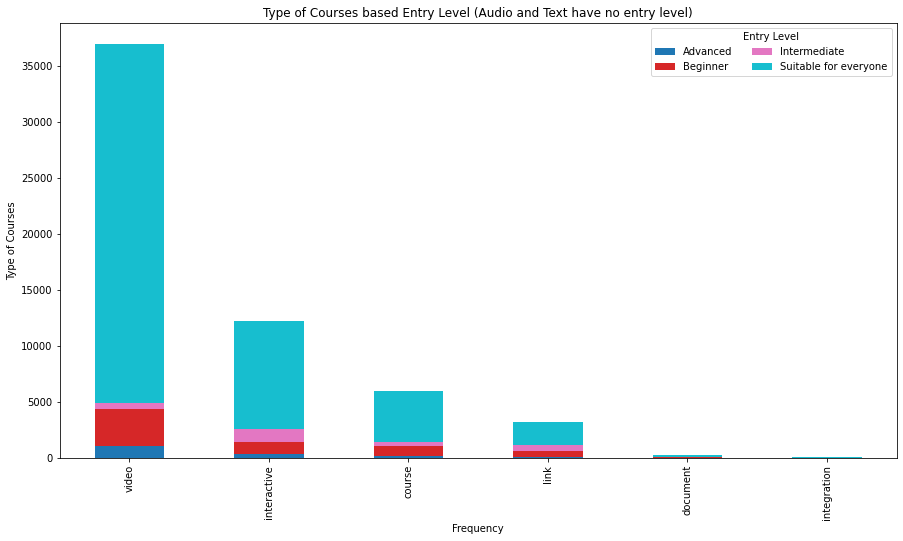

In [68]:
data = pd.pivot_table(df[['type','attributes.entry_level.value','id']], values='id',index='type', columns=['attributes.entry_level.value'], aggfunc='count')
data = data.sort_values(by='Suitable for everyone', ascending=False)


data.plot(kind='bar', stacked=True, colormap='tab10', figsize=(15, 8))
#get handles and labels
handles, labels = plt.gca().get_legend_handles_labels()
order = [0,1,2,3]
plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order], title='Entry Level', loc="upper right", ncol=2) 
plt.xlabel("Frequency")
plt.ylabel("Type of Courses")
plt.title('Type of Courses based Entry Level (Audio and Text have no entry level)')
plt.show()

In [94]:
data = pd.pivot_table(df[['provider.name','type','attributes.entry_level.value','id']], values='id',index=['provider.name','type'], columns=['attributes.entry_level.value'], aggfunc='count', margins=True, margins_name='All').reset_index()
data.sort_values(by=['provider.name','All'], ascending=[True,False])

attributes.entry_level.value,provider.name,type,Advanced,Beginner,Intermediate,Suitable for everyone,All
0,100% Effective,interactive,NaN,3.0,1.0,16.0,20
1,180 Skills,course,23.0,62.0,13.0,231.0,329
3,365 Careers,video,NaN,27.0,NaN,941.0,968
2,365 Careers,course,NaN,1.0,NaN,18.0,19
4,AMC,interactive,NaN,NaN,NaN,172.0,172
5,AMC,course,NaN,NaN,NaN,4.0,4
6,AMC and eLearning Products,course,NaN,7.0,NaN,3.0,10
7,Academy of Insurance,interactive,NaN,1.0,2.0,1.0,4
8,Access Cyber Awareness & Resilience,interactive,NaN,NaN,NaN,43.0,43
9,Access Group,interactive,NaN,NaN,NaN,4.0,4


### 4.2 Type of Courses based on Provider

In [24]:
df.groupby(['type'])['provider.name'].nunique().sort_values(ascending=False)

type
course         158
interactive    135
video           43
document         7
link             5
audio            3
integration      1
text             1
Name: provider.name, dtype: int64

In [40]:
df['provider.name'].value_counts()

CreativeLive                    26589
Stone River eLearning            6989
Packt                            5221
Skillsoft                        3133
Simon Sez IT                     2854
                                ...  
Bullyology Upstander Academy        1
Innodemia                           1
iHASCO                              1
Voice of Health                     1
PAF Feedback                        1
Name: provider.name, Length: 246, dtype: int64

#### 4.2.1 The Career Conversation is focused to only provide text-based courses, which prioritize on 'Personal Development'

In [32]:
# Who is the provider for the text-based courses?
df[df['type']=='text']['provider.name'].unique()

array(['The Career Conversation'], dtype=object)

In [37]:
# For text-based courses, they prioritise on topic of 'Personal Development'
df[df['type']=='text']['attributes.topics'].value_counts()

[{'value': 'Personal Development', 'key': 21}, {'value': 'General Personal Development', 'key': 67}]                   45
[{'value': 'Business Skills', 'key': 65}, {'value': 'Leadership', 'key': 60}]                                           2
[{'value': 'Business Skills', 'key': 65}, {'value': 'Project Management', 'key': 61}]                                   1
[{'value': 'Business Skills', 'key': 65}, {'value': 'Entrepreneurship', 'key': 25}]                                     1
[{'value': 'Business Skills', 'key': 65}, {'value': 'Leadership', 'key': 60}, {'value': 'Negotiation', 'key': 140}]     1
Name: attributes.topics, dtype: int64

#### 4.2.2 CreativeLive is the largest content provider in Go1, where it is the only provider of integration-based courses which focus on topic of 'Technology Skills, Design & Animation and Photography'

In [38]:
# Who is the provider for the integration-based courses?
df[df['type']=='integration']['provider.name'].unique()

array(['CreativeLive'], dtype=object)

In [39]:
# For integration-based courses, they prioritise on topic of 'Technology Skills, Design & Animation and Photography'
df[df['type']=='integration']['attributes.topics'].value_counts()

[{'value': 'Technology Skills', 'key': 64}, {'value': 'Design and Animation', 'key': 1}, {'value': 'Photography', 'key': 111}]    31
[{'value': 'Business Skills', 'key': 65}, {'value': 'Entrepreneurship', 'key': 25}]                                                2
[{'value': 'Business Skills', 'key': 65}, {'value': 'Marketing', 'key': 28}]                                                       1
[{'value': 'Business Skills', 'key': 65}, {'value': 'General Management', 'key': 26}]                                              1
Name: attributes.topics, dtype: int64

In [42]:
# 54% of the video-based courses was actually provided by CreativeLive
df[df['provider.name']=='CreativeLive']['type'].value_counts()

video          24995
course          1559
integration       35
Name: type, dtype: int64

In [43]:
df[df['type']=='video']['provider.name'].value_counts(normalize=True)

CreativeLive                        0.542485
Stone River eLearning               0.137146
Packt                               0.102290
Simon Sez IT                        0.059121
Prositions, Inc.                    0.024872
TJ Walker                           0.023201
365 Careers                         0.021009
Sarder Learning                     0.020098
Mi-Crow                             0.015019
LearnBox                            0.008052
Channel 1 Creative Media            0.006034
Pearls of Wisdom                    0.005600
SkillPath                           0.004579
Sandler                             0.004493
SEND Group                          0.003342
Global Ethics University            0.002670
LearningPlanet                      0.002561
Seven Dimensions                    0.002214
Process Management International    0.002084
Learning Lounge                     0.001867
StoryArc                            0.001671
Gardeners Not Mechanics             0.001606
Mind Chann

### 4.3 Unique Tags

In [44]:
# df[df['tags'].isna()]
# How many empty tags
len(df[df["tags"].str.len() == 0])

7432

In [45]:
# Find the unique tag and its frequency
# pd.set_option("display.max_row", None)
tags = [tag for tags in df['tags'] for tag in tags]
uni_tags_freq = pd.DataFrame({'Tag':Counter(tags).keys(), 'Frequency':Counter(tags).values()}).sort_values(by='Frequency',ascending=False)
len(uni_tags_freq)

29687

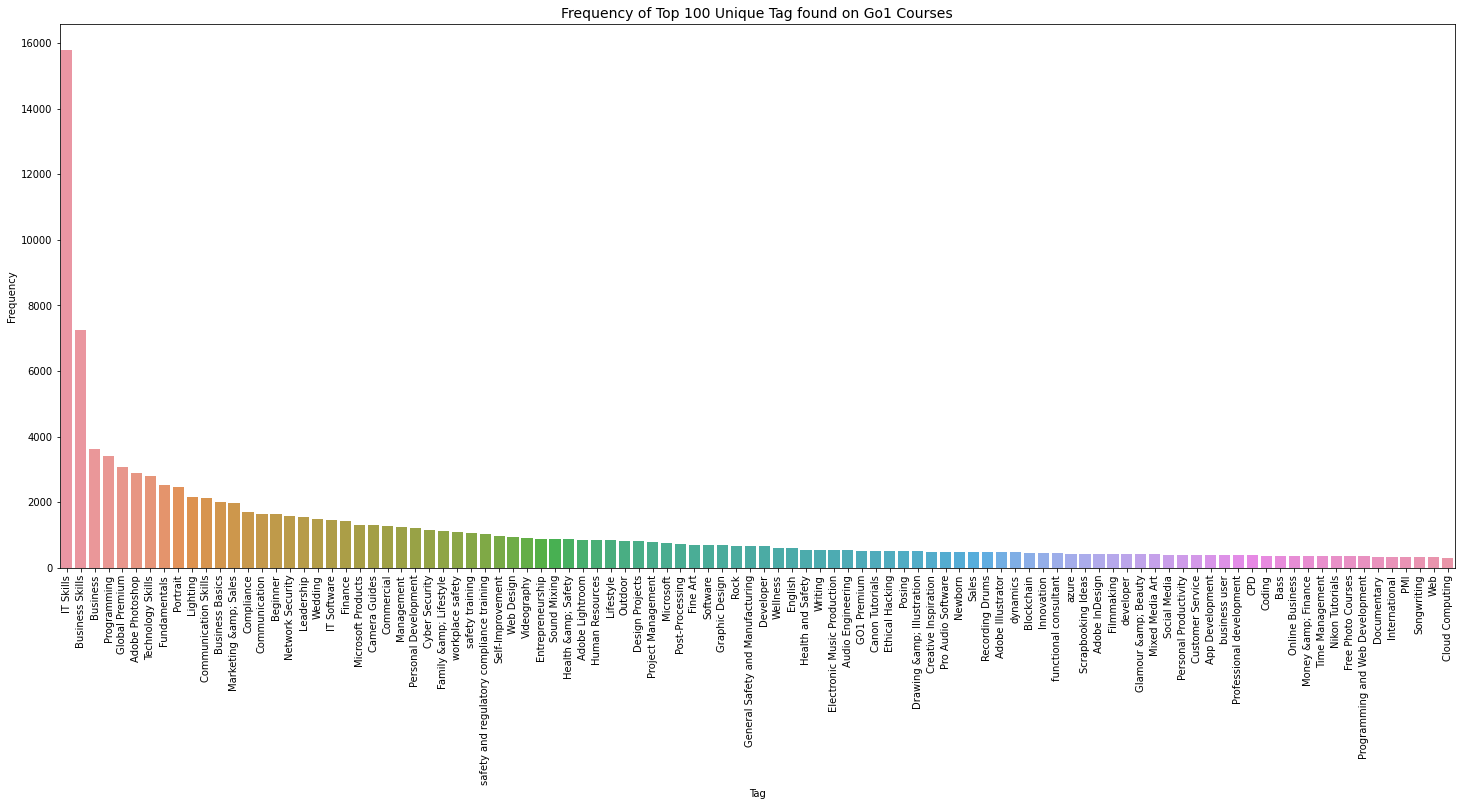

In [46]:
plt.figure(figsize=(25,10))
sns.barplot(x='Tag',y='Frequency', data=uni_tags_freq[:100])
plt.title('Frequency of Top 100 Unique Tag found on Go1 Courses', fontsize=14)
plt.xticks(rotation=90, fontsize=10)
plt.show()

### 4.4 Unique Topics

In [47]:
# Fill in N/A with empty list
# df[df['attributes.topics'].isna()]
df['attributes.topics'] = df['attributes.topics'].apply(lambda d: d if isinstance(d, list) else [])

In [48]:
# Empty Topic
len(df[df["attributes.topics"].str.len() == 0])

193

In [49]:
# Empty Topic but with Tags
len(df[(df["tags"].str.len() != 0) & (df["attributes.topics"].str.len() == 0)])

161

In [50]:
# Empty Topic but with Tags for Courses which are not in English language
df[(df["tags"].str.len() != 0) & (df["attributes.topics"].str.len() == 0) & (df['language']!='en')]['tags']

4346     [Canadian French, General Safety and Manufactu...
4444     [Canadian French, General Safety and Manufactu...
4933                          [Communication, Asertividad]
9643     [Canadian French, French, General Safety and M...
9730                  [Sales, Calidad, Clientes, Servicio]
10019    [Spanish, General Safety and Manufacturing, Gl...
14235    [Spanish, Construction and Heavy Equipment, Co...
17346                  [Personal Development, Creatividad]
17666                   [Personal Development, Innovacion]
18475    [Canadian French, General Safety and Manufactu...
19315    [Business Skills, General Management, Change M...
22348    [Portuguese, Drug &amp; Alcohol Policies, Heal...
22349    [Spanish, Drug &amp; Alcohol Policies, Health ...
22350    [German, Drug &amp; Alcohol Policies, Health a...
22394    [Dutch, Drug &amp; Alcohol Policies, Health an...
23624               [Communication, Comunicacion, Empatia]
24201    [Spanish, General Safety and Manufacturing, Ge.

In [44]:
# Empty Topic and Tag
len(df[(df["tags"].str.len() == 0) & (df["attributes.topics"].str.len() == 0)])

32

In [51]:
# Find the unique topic and its frequency
pd.set_option("display.max_row", None)
topics = [topic['value'] for topics in df['attributes.topics'] for topic in topics]
uni_topics_freq = pd.DataFrame({'Topic':Counter(topics).keys(), 'Frequency':Counter(topics).values()}).sort_values(by='Frequency',ascending=False)
uni_topics_freq

,Topic,Frequency
15,Technology Skills,40040
3,Business Skills,20285
16,Design and Animation,15812
17,Photography,12812
36,IT Software,8157
18,Safety and Compliance,7134
0,Personal Development,7054
73,Microsoft Products,6211
31,"Devops, Networking and Security",5943
11,Sector-specific,5594


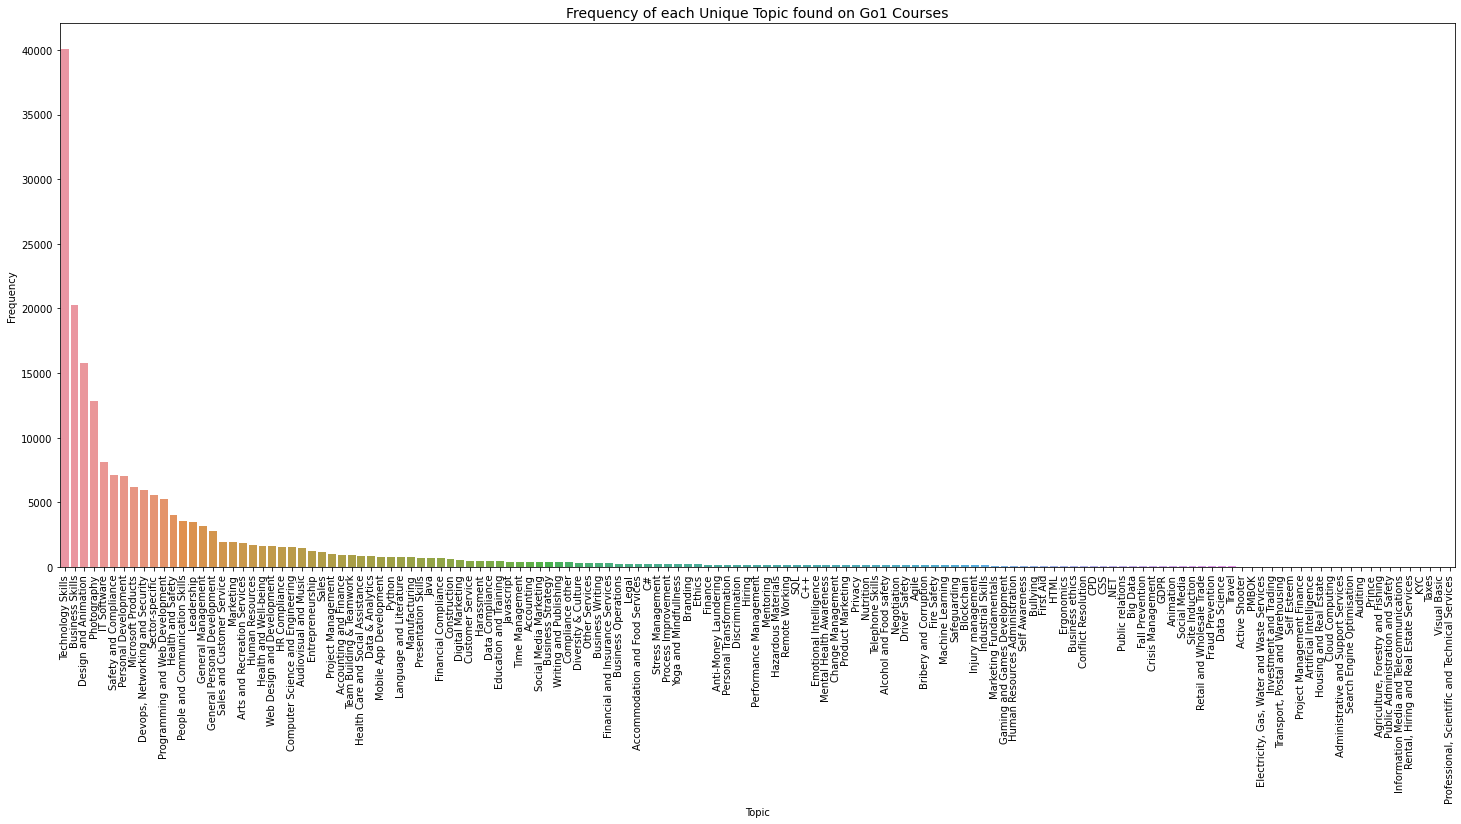

In [15]:
plt.figure(figsize=(25,10))
sns.barplot(x='Topic',y='Frequency', data=uni_topics_freq)
plt.title('Frequency of each Unique Topic found on Go1 Courses', fontsize=14)
plt.xticks(rotation=90, fontsize=10)
plt.show()

#### Observation:
- After checking on Go1 platform, only realise the topics could be put into three levels

In [159]:
lvl = pd.DataFrame(df['attributes.topics.list'].tolist(), columns = ['topic_level_1', 'topic_level_2', 'topic_level_3'])
lvl.drop_duplicates()

,topic_level_1,topic_level_2,topic_level_3
0,Personal Development,Health and Well-being,None
1,Personal Development,Writing and Publishing,None
2,Business Skills,General Management,None
3,Personal Development,General Personal Development,None
5,Business Skills,People and Communication Skills,None
6,Business Skills,Leadership,Team Building & Teamwork
8,Business Skills,Entrepreneurship,None
9,Personal Development,Audiovisual and Music,None
10,Business Skills,Leadership,None
11,Sector-specific,Health Care and Social Assistance,None


#### 4.4.1 Topics under each Topic Category

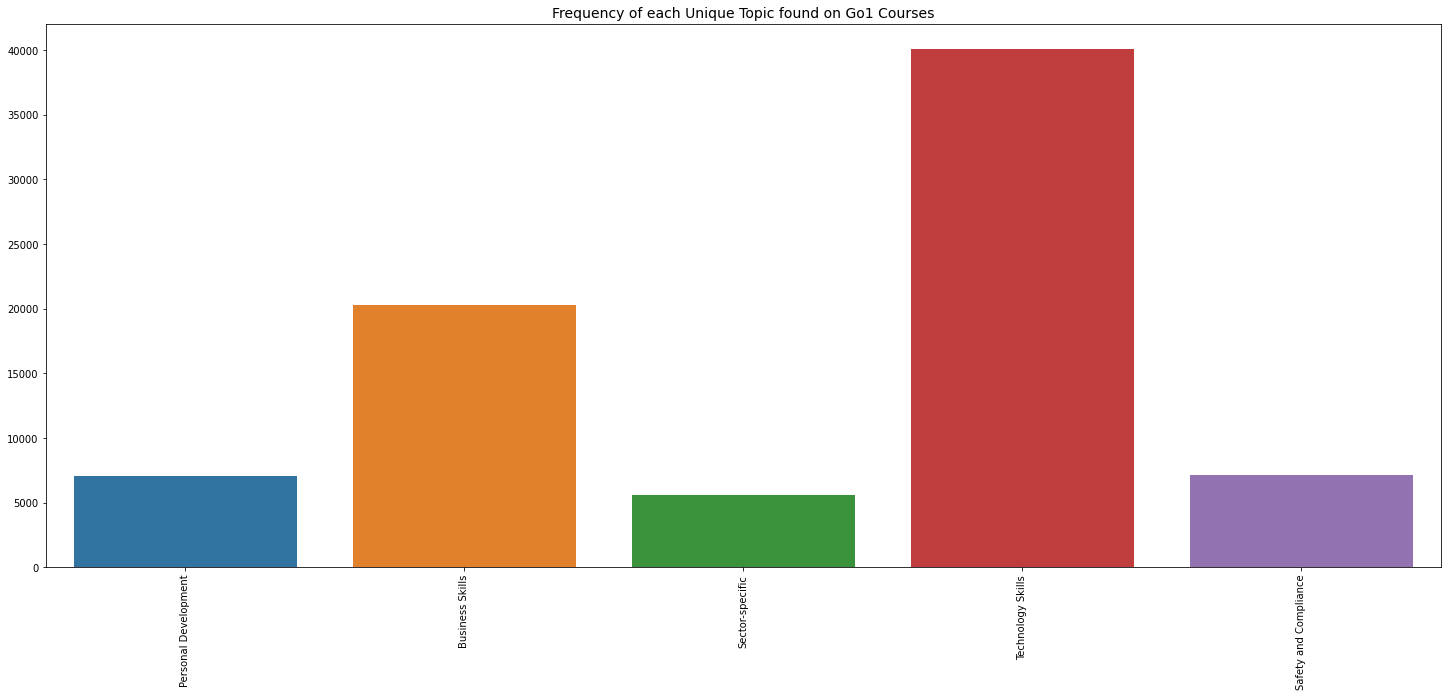

In [173]:
plt.figure(figsize=(25,10))
sns.barplot(x=list(Counter(lvl['topic_level_1']).keys()), y=list(Counter(lvl['topic_level_1']).values()), data=lvl)
plt.title('Frequency of each Unique Topic found on Go1 Courses', fontsize=14)
plt.xticks(rotation=90, fontsize=10)
plt.show()

In [140]:
topic_data = course_search_based_on_topic('Sector-specific')

In [142]:
uni_topics_freq[1:]['Frequency'].sum()

5594

In [141]:
ind_topic = [topic['value'] for topics in topic_data['attributes.topics'] for topic in topics]
uni_topics_freq = pd.DataFrame({'Topic':Counter(ind_topic).keys(), 'Frequency':Counter(ind_topic).values()}).sort_values(by='Frequency',ascending=False)
uni_topics_freq

,Topic,Frequency
0,Sector-specific,5594
3,Arts and Recreation Services,1886
1,Health Care and Social Assistance,888
8,Manufacturing,759
7,Construction,630
2,Education and Training,433
10,Other Services,321
4,Financial and Insurance Services,279
11,Accommodation and Food Services,246
15,Retail and Wholesale Trade,55


### 4.5 Languages

In [52]:
df['language'].value_counts()

en         73611
es          2025
fr           897
de           896
zh           510
ja           368
pt-br        328
pt           276
it           223
nl           146
pl           138
cs           128
th           105
tr            63
ko            62
ro            61
el            55
hu            55
ar            54
ru            46
hr            38
id            35
vi            27
hi            26
ms            23
fr-ca         21
nb            21
fi            18
sv            18
da            15
German         4
De             2
English        2
cz             1
es-do          1
es-es          1
Name: language, dtype: int64

In [118]:
# Find courses under specific topic:
def course_search_based_on_topic(topic):
    ind_list = []
    for row in range(len(df['attributes.topics.list'])):
        if topic in df['attributes.topics.list'][row]:
            ind_list.append(row)
    return df.iloc[ind_list]

In [155]:
course_search_based_on_topic('.NET').head()

,id,type,title,published,description,image,created_time,updated_time,decommission_time,remove_time,language,tags,items,items_count,assessable,collections,portal_collection,summary,previewable,authors,delivery.duration,delivery.mode,pricing.currency,pricing.price,pricing.tax,pricing.tax_included,provider.id,provider.name,subscription.licenses,subscription.package,attributes.region_restrictions,attributes.wcag,attributes.topics,attributes.roles,attributes.industry,attributes.playlist_type,attributes.locale,attributes.region_relevance,attributes.learning_outcomes,attributes.skills,attributes.mobile_optimised,attributes.assessable,attributes.provider,attributes.entry_level.value,attributes.entry_level.key,attributes.featured_status,provider.logo,attributes.entry_level,attributes.featured_locale,reviews.count,reviews.rating,attributes.featured_timestamp,attributes.topics.list
86,5293865,interactive,".NET Framework 4.5.1, Part 1 of 3: Overview",True,<p><strong>Course description</strong></p><p>....,https://media.go1static.com/image/upload/q_aut...,2018-08-22T23:40:58+00:00,2022-01-05T04:39:43+00:00,None,None,en,"[Developer, Programming, Microsoft, Visual Stu...",[],0,True,[],False,This course is for those with prior experience...,True,"[{'name': 'LearnNow Online', 'last_name': 'Onl...",228,self-paced,USD,0,0,True,4546598,LearnNow Online,-1,premium,"[{'value': 'GLOBAL', 'key': 163}]",,"[{'value': 'Technology Skills', 'key': 64}, {'...",NaN,[],,"[{'value': 'en-US', 'key': 493}]","[{'value': 'GLOBAL', 'key': 495}]","[How the .NET framework is built, LINQ, Entity...",NaN,1,,NaN,NaN,NaN,0.0,https://res.cloudinary.com/go1/image/upload/v1...,[],NaN,NaN,NaN,NaN,"[Technology Skills, Programming and Web Develo..."
87,5293808,interactive,".NET Framework 4.5.1, Part 2 of 3: One ASP.NET",True,<p><strong>Course description</strong></p><p>M...,https://media.go1static.com/image/upload/q_aut...,2018-08-22T23:37:18+00:00,2021-07-16T10:56:07+00:00,None,None,en,"[Developer, Programming, Microsoft, Visual Stu...",[],0,True,[],False,This course is for those with prior experience...,True,"[{'name': 'LearnNow Online', 'last_name': 'Onl...",208,self-paced,USD,0,0,True,4546598,LearnNow Online,-1,premium,"[{'value': 'GLOBAL', 'key': 163}]",,"[{'value': 'Technology Skills', 'key': 64}, {'...",NaN,[],,"[{'value': 'en-US', 'key': 493}]","[{'value': 'GLOBAL', 'key': 495}]","[How the .NET framework is built, LINQ, Entity...",NaN,1,,NaN,NaN,NaN,0.0,https://res.cloudinary.com/go1/image/upload/v1...,[],NaN,NaN,NaN,NaN,"[Technology Skills, Programming and Web Develo..."
1517,6123377,interactive,ASP.NET 4 AJAX and jQuery Using Visual Basic 2...,True,<p><strong>Course description</strong></p>\n\n...,https://media.go1static.com/image/upload/v1540...,2018-10-25T00:08:00+00:00,2021-07-16T11:00:44+00:00,None,None,en,"[Developer, Programming, Microsoft, Visual Stu...",[],0,True,[],False,,True,"[{'name': 'LearnNow Online', 'last_name': 'Onl...",185,self-paced,USD,0,0,True,4546598,LearnNow Online,-1,premium,"[{'value': 'GLOBAL', 'key': 163}]",0,"[{'value': 'Technology Skills', 'key': 64}, {'...",NaN,[],,"[{'value': 'en-US', 'key': 493}]","[{'value': 'GLOBAL', 'key': 495}]",None,NaN,1,0,NaN,NaN,NaN,0.0,https://res.cloudinary.com/go1/image/upload/v1...,[],NaN,NaN,NaN,NaN,"[Technology Skills, Programming and Web Develo..."
1518,6123450,interactive,ASP.NET 4 AJAX and jQuery Using Visual Basic 2...,True,<p><strong>Course description</strong></p>\n\n...,https://media.go1static.com/image/upload/v1540...,2018-10-25T00:12:47+00:00,2021-07-16T11:00:46+00:00,None,None,en,"[Developer, Programming, Microsoft, Visual Stu...",[],0,True,[],False,,True,"[{'name': 'LearnNow Online', 'last_name': 'Onl...",164,self-paced,USD,0,0,True,4546598,LearnNow Online,-1,premium,"[{'value': 'GLOBAL', 'key': 163}]",0,"[{'value': 'Technology Skills', 'key': 64}, {'...",NaN,[],,"[{'value': 'en-US', 'key': 493}]","[{'value': 'GLOBAL', 'key': 495}]",None,NaN,1,0,NaN,NaN,NaN,0.0,https://res.cloudinary.com/go1/ima

In [ ]:
df['language'].value_counts()

In [98]:
len(df[pd.notnull(df['summary'])])

80300

In [95]:
df[pd.notnull(df['summary'])].head(10)

,id,type,title,description,image,created_time,updated_time,language,tags,summary,previewable,authors,delivery.duration,pricing.currency,pricing.tax,pricing.tax_included,provider.id,provider.name,subscription.licenses,attributes.region_restrictions,attributes.wcag,attributes.topics,attributes.locale,attributes.region_relevance,attributes.learning_outcomes,attributes.mobile_optimised,attributes.assessable,attributes.entry_level.value,attributes.entry_level.key,attributes.featured_status,provider.logo,attributes.featured_locale,reviews.count,reviews.rating,attributes.featured_timestamp
0,28398490,video,"""#usailgomito (#sleevesneeze)""",<p>Ora più che mai è importante impedire che i...,https://media.go1static.com/image/upload/v1604...,2020-11-09T17:35:31+00:00,2022-03-25T06:52:46+00:00,it,"[Personal Development, Health and Wellbeing]",,True,"[{'name': 'Thrive Learning', 'last_name': 'Lea...",1,USD,0,True,19464883,Thrive Learning,-1,"[{'value': 'GLOBAL', 'key': 163}]",,"[{'value': 'Personal Development', 'key': 21},...","[{'value': 'en-UK', 'key': 494}]","[{'value': 'GLOBAL', 'key': 495}]",[How to #sleevesneeze],1,,Suitable for everyone,491.0,0.0,NaN,NaN,NaN,NaN,NaN
1,8569489,video,"""Aha Moment"" Exercise (Wired for Story: How to...",<p>Do you feel like you have a book inside of<...,https://cdn.go1static.com/s3.go1.service/creat...,2019-03-16T09:28:21+00:00,2020-12-23T07:52:11+00:00,en,"[Writing, Creative Inspiration, Communication ...",,True,"[{'name': 'Creative Live', 'last_name': 'Live'...",12,AUD,0,True,4878185,CreativeLive,-1,"[{'value': 'GLOBAL', 'key': 163}, {'value': 'Z...",0,"[{'value': 'Personal Development', 'key': 21},...","[{'value': 'en-US', 'key': 493}]","[{'value': 'GLOBAL', 'key': 495}]",None,1,,Suitable for everyone,491.0,0.0,https://res.cloudinary.com/go1/image/upload/v1...,NaN,NaN,NaN,NaN
2,13887319,link,"""Blue Collar"" Workers",<p>Managing blue-collar workers can sometimes ...,https://media.go1static.com/image/upload/v1574...,2019-11-27T07:17:58+00:00,2021-09-29T03:43:27+00:00,en,[],An article on blue collar workers and what you...,False,[],11,USD,0,True,13882707,Mind Tools,-1,"[{'value': 'GLOBAL', 'key': 163}]",0,"[{'value': 'Business Skills', 'key': 65}, {'va...","[{'value': 'en-US', 'key': 493}]","[{'value': 'GLOBAL', 'key': 495}]","[What is a blue collar worker, The management ...",1,0,Suitable for everyone,491.0,0.0,https://res.cloudinary.com/go1/image/upload/v1...,NaN,NaN,NaN,NaN
3,13888194,link,"""Cautious"" or ""Courageous""?",Understanding your risk propensity and how it ...,https://media.go1static.com/image/upload/v1574...,2019-11-27T07:58:42+00:00,2021-09-29T03:41:26+00:00,en,[],Understanding your risk propensity and how it ...,False,[],8,USD,0,False,13882707,Mind Tools,-1,"[{'value': 'GLOBAL', 'key': 163}]",0,"[{'value': 'Personal Development', 'key': 21},...","[{'value': 'en-US', 'key': 493}]","[{'value': 'GLOBAL', 'key': 495}]","[How to understand your risk propensity, The r...",1,0,Suitable for everyone,491.0,0.0,https://res.cloudinary.com/go1/image/upload/v1...,NaN,NaN,NaN,NaN
4,36466733,course,"""DUPLICATED VIDEO Drive-The surprising truth a...",<p>Challenging traditional belief that externa...,https://media.go1static.com/image/upload/v1650...,2022-04-18T12:33:13+00:00,2022-04-22T07:29:40+00:00,en,"[Drive, Daniel H Pink, Operating System, Motiv...",Explore why intrinsic rewards are the most imp...,False,"[{'name': 'Emeritus Online', 'last_name': 'Onl...",21,AUD,0,False,36188067,Emeritus,-1,"[{'value': 'GLOBAL', 'key': 163}]",,"[{'value': 'Personal Development', 'key': 21},...",NaN,"[{'value': 'GLOBAL', 'key': 495}]",[Chart out the reasons why our current motivat...,1,0,Beginner,488.0,0.0,NaN,NaN,NaN,NaN,NaN
5,36172735,interactive,"""Das ist nicht meine Schuld!"" - ""That's not my...",In deiner Gruppe bestreitet jeder seinen eigen...,https://media.go1static.com/image/upload/v1629...,2021-06-24T09:07:58+00:00,2021-08-25T05:10:53+00:00,de,[2021],Das Teilen von Verantwortlichkeiten bildet ein...